# Cross temporal generalization

In the previous examples, we simulated multivariate patterns representing specific experimental conditions of interest, within specific time windows and tested the effects in a time resolved fashion. Under the hood, the simulator embedded multivariate patterns that are consistant across the entire specified time windows. What this means is that if you apply a cross temporal generalization technique, as described by {cite:t}`king2014characterizing`, you will observe cross temporal generalization of the decoding across the entire time window. We will show that below. But importantly, the toolbox is fully flexible, and we can simulate all kind of cross temporal generalization patterns.  

## 1. Simulating data with cross temporal generalization patterns for each condition

We can repeat the same simulation as in all previous examples and apply cross temporal generalization technique to see what that looks like:

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import gamma as gamma_dist
import matplotlib.pyplot as plt
from multisim import Simulator
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import GeneralizingEstimator, cross_val_multiscore

# Creating the design matrix of our 2 by two balanced design:
X = np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T

# Add descriptors:
cond_names = ["category", "attention"]
X = pd.DataFrame(
    X, columns=cond_names
)  # Add a column for the interaction between category and attention
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"},
}

# Specifying the effects:
effects = [
    {"condition": "category", "windows": [0.1, 0.3], "effect_size": 0.5},
    {"condition": "attention", "windows": [0.3, 0.5], "effect_size": 0.5},
]  # Packaging them in a list to pass to the simulator class

# Data parameters:
n_channels = 32  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 2  # Variance of the data
ch_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz
tmin = -0.25
tmax = 2.0

# Generate our kernel:
t = np.arange(0, 1, 1 / sfreq)  # time vector (in seconds)
kernel = gamma_dist(a=2, scale=0.05).pdf(t)[t < 0.2]
kernel /= kernel.max()  # Normalize to peak

# Between subject noise:
intersub_noise_std = 1 / 8

# Simulating the data:
sims = Simulator(
    X,  # Design matrix
    effects,  # Effects to simulate
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

Now let's apply cross temporal generalization decoding:

In [9]:
# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

scores_category = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
scores_category = np.array(scores_category)

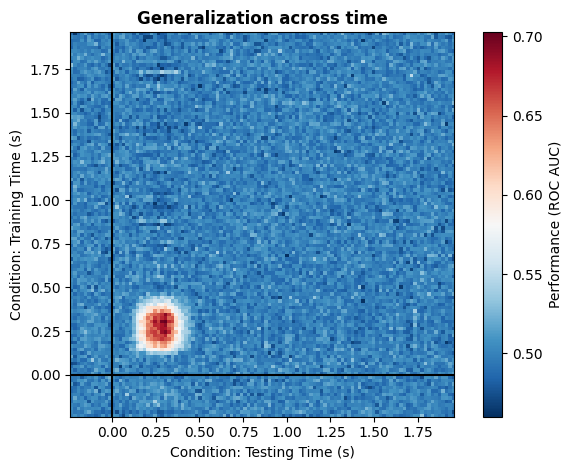

In [10]:
# Plot the results
fig, ax = plt.subplots()
# Plot the results of category decoding:
im = ax.imshow(
    np.mean(scores_category, axis=0),
    cmap="RdBu_r",
    origin="lower",
    extent=epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    "Condition: Testing Time (s)",
)
ax.set_ylabel("Condition: Training Time (s)")
ax.set_title("Generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.tight_layout()
plt.show()

As we can clearly see, we have decoding that generalize across all time points within the specified window. 

## 2. Simulating data with effects shared across time windows
With the toolbox, we can also specify an effect to be expressed in several time windows relying on the same multivariate pattern, yielding generalization between time windows. For that, we simply need to specify more time window within a particular effect:

In [11]:
# Specifying the effects:
effects = [
    {"condition": "category", "windows": [[0.1, 0.3], [0.7, 0.9]], "effect_size": 0.5},
    {"condition": "attention", "windows": [0.3, 0.5], "effect_size": 0.5},
]  # Packaging them in a list to pass to the simulator class

# Simulating the data:
sims = Simulator(
    X,  # Design matrix
    effects,  # Time window of the effects
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

Now let's do the cross temporal generalization to showcase what that looks like:

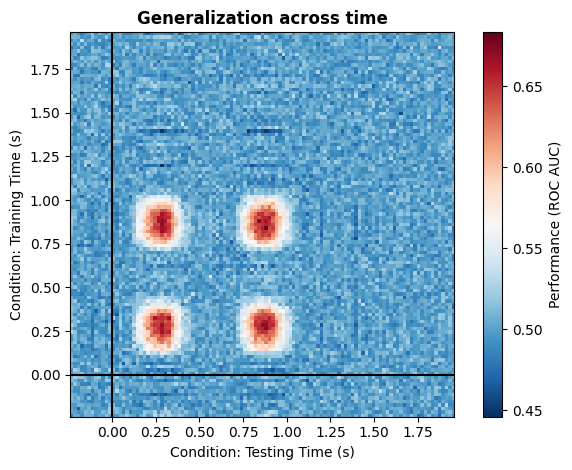

In [12]:
# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

scores_category = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)

# Plot the results
fig, ax = plt.subplots()
# Plot the results of category decoding:
im = ax.imshow(
    np.mean(scores_category, axis=0),
    cmap="RdBu_r",
    origin="lower",
    extent=epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    "Condition: Testing Time (s)",
)
ax.set_ylabel("Condition: Training Time (s)")
ax.set_title("Generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.tight_layout()
plt.show()

This is the kind of effect you would expect if there is a reinstantiation of the same activation pattern encoding specific information at two different time points, such as when you have memory reinstantiation after a delay period or something like that.

## 3. Simulating data with effects unique to each time windows

With the toolbox, we can equally well simulate multivariate patterns that are unique. This would be a case where the same information is represented at two independent time points, but in each case relying on different neuronal population. In our example of faces vs. objects, you can think of a first representation in visual areas, followed by a representation in the PFC. You would not expect any generalization between the two, because they rely on completely different parts of the brain. To simulate such data, we can simply pass two different dictionaries specifying the same effect at different time windows. Under the hood, the simulator will generate two patterns from two different distributions, ensuring that there is no generalization.

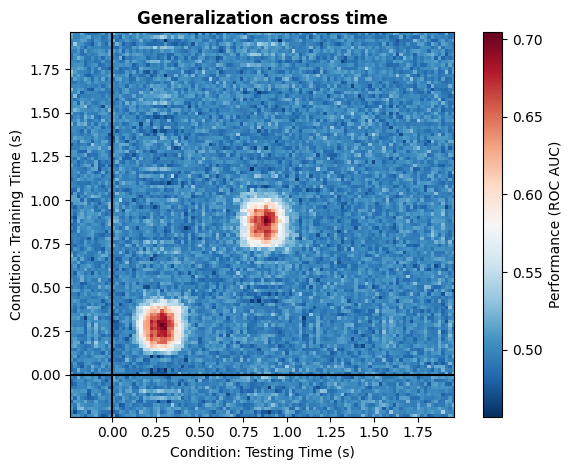

In [13]:
# Specifying the effects:
effects = [
    {"condition": "category", "windows": [0.1, 0.3], "effect_size": 0.5},
    {"condition": "category", "windows": [0.7, 0.9], "effect_size": 0.5},
]  # Packaging them in a list to pass to the simulator class

# Simulating the data:
sims = Simulator(
    X,  # Design matrix
    effects,
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

scores_category = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
scores_category = np.array(scores_category)

# Plot the results
fig, ax = plt.subplots()
# Plot the results of category decoding:
im = ax.imshow(
    np.mean(scores_category, axis=0),
    cmap="RdBu_r",
    origin="lower",
    extent=epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    "Condition: Testing Time (s)",
)
ax.set_ylabel("Condition: Training Time (s)")
ax.set_title("Generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.tight_layout()
plt.show()

## 4. Full modularity
With this simple implementation, you can simulate any kind of cross temporal generalization pattern presented in the paper from King et al. (2014) {cite}`king2014characterizing` quite easily. Below are just a few example, but note that by using kernels in a smart way, you can implement quite literally any pattern

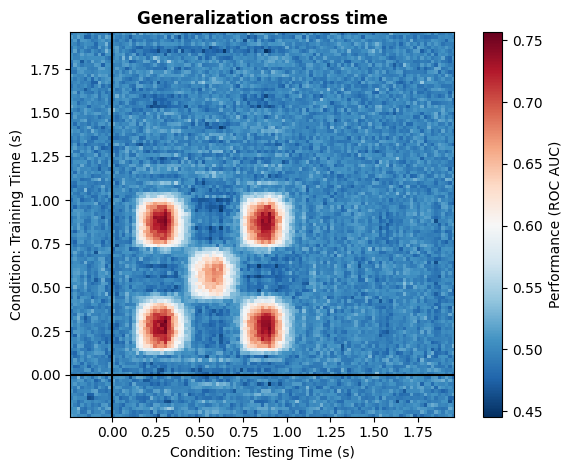

In [14]:
# Specifying the effects:
effects = [
    {"condition": "category", "windows": [[0.1, 0.3], [0.7, 0.9]], "effect_size": 0.5},
    {"condition": "category", "windows": [0.4, 0.6], "effect_size": 0.5},
]  # Packaging them in a list to pass to the simulator class

# Simulating the data:
sims = Simulator(
    X,  # Design matrix
    effects,
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

scores_category = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
scores_category = np.array(scores_category)

# Plot the results
fig, ax = plt.subplots()
# Plot the results of category decoding:
im = ax.imshow(
    np.mean(scores_category, axis=0),
    cmap="RdBu_r",
    origin="lower",
    extent=epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    "Condition: Testing Time (s)",
)
ax.set_ylabel("Condition: Training Time (s)")
ax.set_title("Generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (ROC AUC)")
plt.tight_layout()
plt.show()

In the next tutorial, we will explore the effect size parameter to show how to use it to investigate the relationship between effect size and decoding accuracy and show the impact of trial number, noise and number of features. 

## References
```{bibliography}
:style: unsrt
:filter: docname in docnames
```